In [ ]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from tensorboard.backend.event_processing import event_accumulator

type = "standalone"
plot__ = "loss"
standal_csv_name = "Loss_train.csv"
# === Function to convert TF events to CSV ===
def convert_tf_to_csv(tfevent_path, save_folder):
    ea = event_accumulator.EventAccumulator(tfevent_path)
    ea.Reload()
    tags = ea.Tags()["scalars"]
    saved_files = []
    for tag in tags:
        events = ea.Scalars(tag)
        df = pd.DataFrame([(e.step, e.wall_time, e.value) for e in events],
                          columns=["step", "wall_time", "value"])
        # Scale by 100 only if ALL values are below 1
        if df['value'].max() <= 1:
            df['value'] = df['value'] * 100
        filename = f"{tag.replace('/', '_')}.csv"
        save_path = os.path.join(save_folder, filename)
        df.to_csv(save_path, index=False)
        saved_files.append(save_path)
        print(f"Saved: {os.path.abspath(save_path)}")
    return saved_files

# === List of TF event files and their metadata ===
df_info = pd.read_csv(f"/Users/julian/projects/University/Period5/FederatedLearning-SNN/{type}.csv")  # must have columns: filepath, folder, aggregation, method, num_clients
tf_event_files = []
for _, row in df_info.iterrows():
    folder = os.path.dirname(row["filepath"])
    filename = os.path.basename(row["filepath"])
    tf_event_files.append((folder, filename, row["aggregation"], row["method"], row["num_clients"]))

print("Starting TF event to CSV conversion...")

for folder, filename, agg, method, n_clients in tf_event_files:
    os.makedirs(folder, exist_ok=True)
    full_path = os.path.join(folder, filename) 
    convert_tf_to_csv(full_path, folder)
print("Conversion done. Waiting 15 seconds before proceeding...")
for remaining in range(15, 0, -1):
    print(f"Continuing in {remaining} seconds...", end='\r')
    time.sleep(1)
print("Proceeding with plotting.\n")

all_csv_files = []
all_metadata = []

for folder, filename, agg, method, n_clients in tf_event_files:
    # List all CSVs generated in the folder after conversion
    files = [f for f in os.listdir(folder) if f.endswith(f"centralized_{plot__}.csv") or f.endswith(standal_csv_name)]
    for f in files:
        all_csv_files.append(os.path.join(folder, f))
        all_metadata.append({
            "filepath": os.path.join(folder, f),
            "aggregation": agg,
            "method": method,
            "num_clients": n_clients
        })

    print(files)

Starting TF event to CSV conversion...
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/surrogate_gradients/standalone/0/Loss_train.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/surrogate_gradients/standalone/0/Acc_train.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/spide/standalone/final_spide_standalone_seed_0/Loss_train.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/spide/standalone/final_spide_standalone_seed_0/Acc_train.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/eventprop/standalone/Loss_train.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/eventprop/standalone/Acc_train.csv
Conversion done. Waiting 15 seconds before proceeding...
Proceeding with plotting...

['Loss_train.csv']
['Loss_train.csv']
['Loss_train.csv']


        step     wall_time     value aggregation     method  num_clients
0          5  1.749378e+09  0.338047  Standalone         SG            0
1          7  1.749378e+09  0.082109  Standalone         SG            0
2         15  1.749378e+09  0.121484  Standalone         SG            0
3         16  1.749378e+09  0.109102  Standalone         SG            0
4         21  1.749378e+09  0.087383  Standalone         SG            0
...      ...           ...       ...         ...        ...          ...
29995  18752  1.749509e+09  0.391111  Standalone  EventProp            0
29996  18755  1.749509e+09  0.391027  Standalone  EventProp            0
29997  18756  1.749509e+09  0.391023  Standalone  EventProp            0
29998  18757  1.749509e+09  0.391074  Standalone  EventProp            0
29999  18759  1.749509e+09  0.390955  Standalone  EventProp            0

[30000 rows x 6 columns]


/var/folders/j7/hsgkr4350rl2cf351s81fqj40000gn/T/ipykernel_96211/1180295291.py:74: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


Saved: plots_loss/standalone_0clients.png


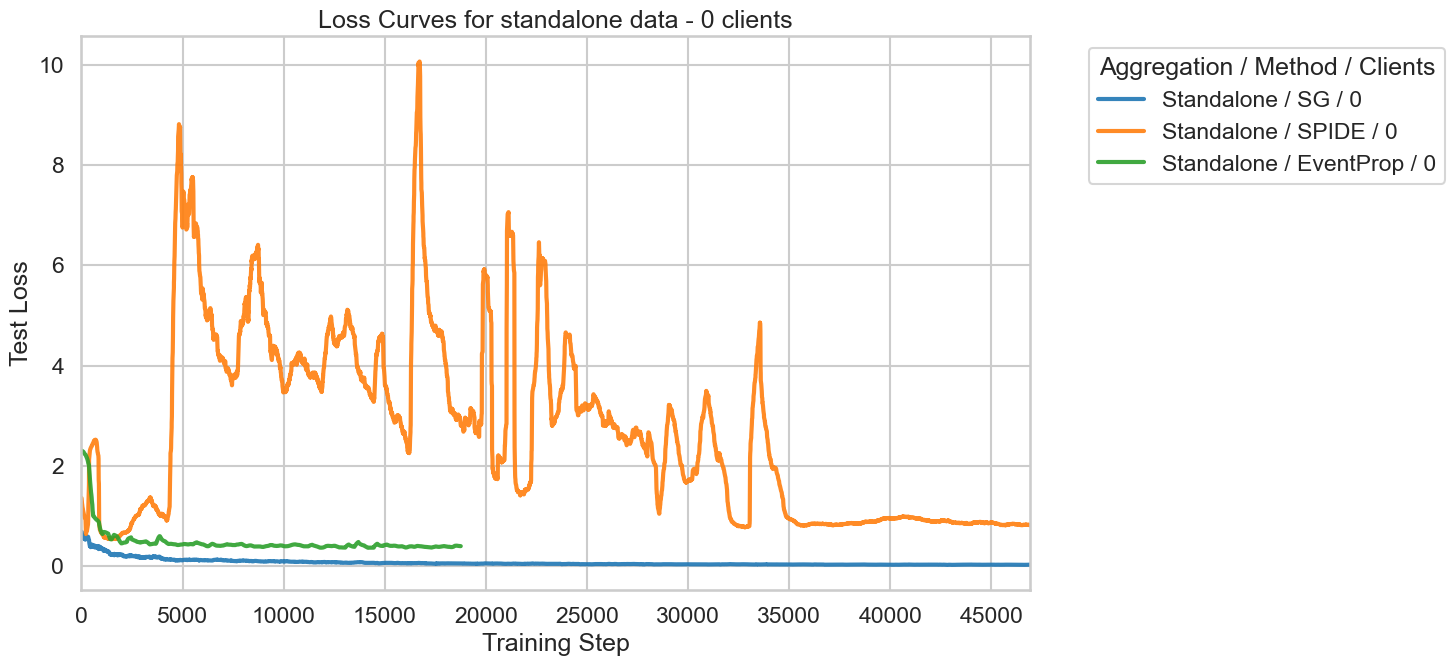

/var/folders/j7/hsgkr4350rl2cf351s81fqj40000gn/T/ipykernel_96211/1180295291.py:139: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


Saved individual: plots_loss/standalone_Standalone___SG___0_individual.png


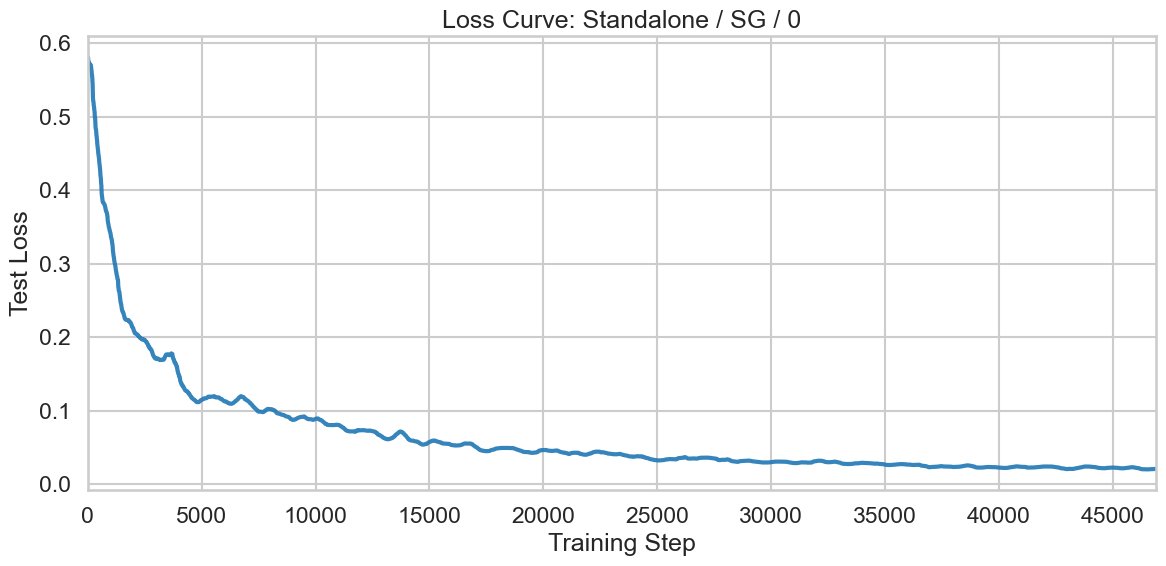

/var/folders/j7/hsgkr4350rl2cf351s81fqj40000gn/T/ipykernel_96211/1180295291.py:139: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


Saved individual: plots_loss/standalone_Standalone___SPIDE___0_individual.png


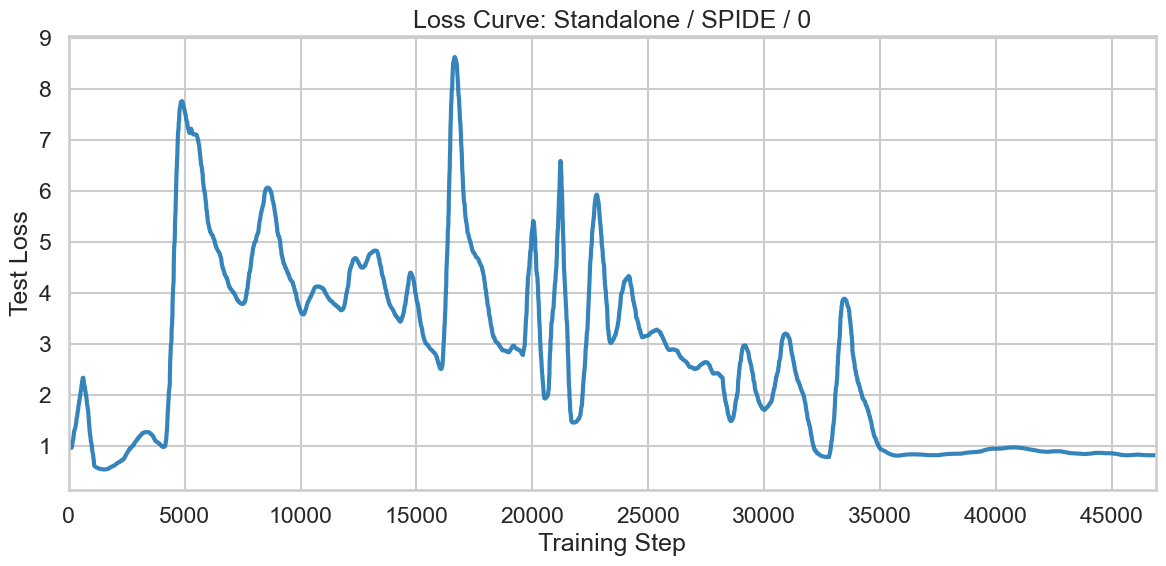

/var/folders/j7/hsgkr4350rl2cf351s81fqj40000gn/T/ipykernel_96211/1180295291.py:139: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


Saved individual: plots_loss/standalone_Standalone___EventProp___0_individual.png


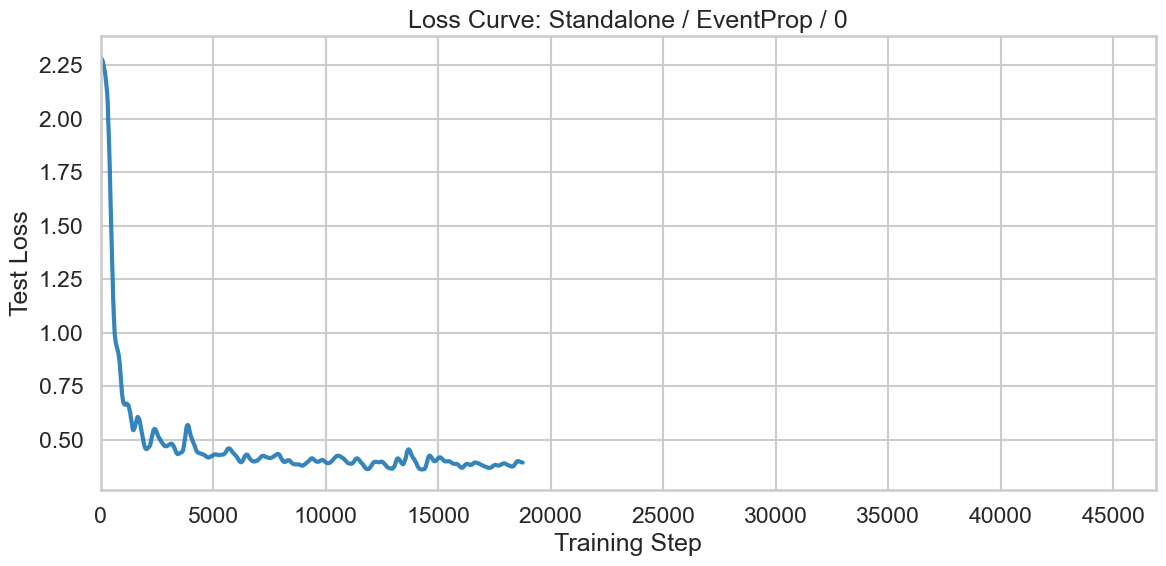

'# --- Plot average accuracy over all runs combined (single curve) ---\navg_df = combined_df[combined_df[\'step\'] <= 10].groupby(\'step\', as_index=False)[\'value\'].mean()\n\nplt.figure(figsize=(10, 6))\nplt.plot(avg_df[\'step\'], avg_df[\'value\'], marker=\'o\', color=\'tab:blue\')\nplt.title(f"Average {plot__.capitalize()} Across All Runs")\nplt.xlabel("Round")\nplt.ylabel(f"Average Test {plot__.capitalize()}")\nplt.grid(True)\nplt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))\nplt.tight_layout()\nplt.show()'

In [36]:
df_meta = pd.DataFrame(all_metadata)

# --- Load CSV data and assign metadata ---
all_dfs = []
for idx, row in df_meta.iterrows():
    try:
        df = pd.read_csv(row['filepath'], encoding='latin1')
        df['aggregation'] = row['aggregation']
        df['method'] = row['method']
        df['num_clients'] = row['num_clients']
        all_dfs.append(df)
    except Exception as e:
        print(f"Skipping {row['filepath']} due to error: {e}")

combined_df = pd.concat(all_dfs, ignore_index=True)

# --- Plot all accuracy curves ---
sns.set(style="whitegrid", context="talk", palette="colorblind")

print(combined_df)
combined_df['label'] = combined_df.apply(
    lambda row: f"{row['aggregation']} / {row['method']} / {row['num_clients']}", axis=1
)

combined_df_small = combined_df[combined_df['step'] <= 10]

# Create plots folder
plots_folder = f"plots_{plot__}"
os.makedirs(plots_folder, exist_ok=True)

# Get unique number of clients
unique_clients = combined_df['num_clients'].unique()

for n_clients in unique_clients:
    # Filter data for this number of clients
    client_df = combined_df[combined_df['num_clients'] == n_clients]
    
    # Apply smoothing to combined plot if standalone
    if type == "standalone":
        # Apply rolling average smoothing to each method separately
        smoothed_dfs = []
        for label in client_df['label'].unique():
            method_df = client_df[client_df['label'] == label].copy()
            if len(method_df) > 100:  # Only smooth if we have enough data points
                window_size = max(50, len(method_df) // 100)  # Adjust window based on data size
                method_df['value'] = method_df['value'].rolling(
                    window=window_size, 
                    center=True, 
                    min_periods=1
                ).mean()
            smoothed_dfs.append(method_df)
        client_df = pd.concat(smoothed_dfs, ignore_index=True)
    
    # Set x-axis limits and ticks based on data type
    if type in ["iid", "non-iid"]:
        client_df = client_df[client_df['step'] <= 10]  # Filter to 10 rounds
        x_limit = (-0.5, 10.5)
        x_ticks = range(11)
    else:  # standalone or other types
        max_step = client_df['step'].max()
        x_limit = (-0.5, max_step + 0.5)
        # For standalone, use automatic tick spacing to avoid overcrowding
        if type == "standalone":
            # Let matplotlib decide tick spacing, but set reasonable limits
            x_ticks = None  # Will use automatic ticking
        else:
            x_ticks = range(int(max_step) + 1)
    
    plt.figure(figsize=(15, 7))
    
    # Different styling for standalone vs federated
    if type == "standalone":
        # For standalone: no markers, use estimator for smoothing
        sns.lineplot(
            data=client_df,
            x='step', y='value',
            hue='label',
            palette='tab10',
            estimator='mean',  # This will smooth the data
            ci=None,  # Remove confidence intervals
            alpha=0.9,
            linewidth=3,
            # No marker for standalone
        )
    else:
        # For federated: keep markers and no smoothing
        sns.lineplot(
            data=client_df,
            x='step', y='value',
            hue='label',
            palette='tab10',
            estimator=None,
            alpha=0.8,
            linewidth=2,
            marker='o'
        )
    
    plt.title(f"{plot__.capitalize()} Curves for {type} data - {n_clients} clients")
    plt.xlabel("Round" if type in ["iid", "non-iid"] else "Training Step")
    plt.ylabel(f"Test {plot__.capitalize()}")
    plt.legend(title="Aggregation / Method / Clients", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    
    # Set x-axis formatting
    if type == "standalone":
        # For standalone, use automatic intelligent ticking
        plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(nbins=10, integer=True))
        plt.xlim(x_limit)
    else:
        plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
        plt.xlim(x_limit)
        plt.xticks(x_ticks)
    
    # Save plot
    filename = f"{type}_{n_clients}clients.png"
    filepath = os.path.join(plots_folder, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")
    plt.show()

    # For standalone, create individual plots for each method
    if type == "standalone":
        unique_labels = client_df['label'].unique()
        for label in unique_labels:
            method_df = client_df[client_df['label'] == label].copy()
            
            # Apply additional smoothing for standalone data
            if len(method_df) > 100:  # Only smooth if we have enough data points
                # Apply rolling average with adaptive window size
                window_size = max(50, len(method_df) // 100)  # Adjust window based on data size
                method_df['value'] = method_df['value'].rolling(
                    window=window_size, 
                    center=True, 
                    min_periods=1
                ).mean()
            
            plt.figure(figsize=(12, 6))
            sns.lineplot(
                data=method_df,
                x='step', y='value',
                color='tab:blue',
                estimator='mean',
                ci=None,
                alpha=0.9,
                linewidth=3
            )
            
            plt.title(f"{plot__.capitalize()} Curve: {label}")
            plt.xlabel("Training Step")
            plt.ylabel(f"Test {plot__.capitalize()}")
            plt.grid(True)
            plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(nbins=10, integer=True))
            plt.xlim(x_limit)
            plt.tight_layout()
            
            # Save individual plot
            safe_label = label.replace('/', '_').replace(' ', '_')
            individual_filename = f"{type}_{safe_label}_individual.png"
            individual_filepath = os.path.join(plots_folder, individual_filename)
            plt.savefig(individual_filepath, dpi=300, bbox_inches='tight')
            print(f"Saved individual: {individual_filepath}")
            plt.show()

"""# --- Plot average accuracy over all runs combined (single curve) ---
avg_df = combined_df[combined_df['step'] <= 10].groupby('step', as_index=False)['value'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_df['step'], avg_df['value'], marker='o', color='tab:blue')
plt.title(f"Average {plot__.capitalize()} Across All Runs")
plt.xlabel("Round")
plt.ylabel(f"Average Test {plot__.capitalize()}")
plt.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()"""

IID combinations: {('FedProx', 'SG'), ('FedProx', 'EventProp'), ('FedOpt', 'SG'), ('FedOpt', 'EventProp'), ('FedAvg', 'Biograd'), ('FedAvg', 'SPIDE'), ('FedProx', 'SPIDE'), ('FedAvg', 'SG'), ('FedOpt', 'SPIDE'), ('FedAvg', 'EventProp')}
Non-IID combinations: {('FedProx', 'SG'), ('FedProx', 'EventProp'), ('FedAvg', 'SPIDE'), ('FedProx', 'SPIDE'), ('FedAvg', 'SG'), ('FedAvg', 'EventProp')}
Intersecting combinations: {('FedProx', 'SG'), ('FedProx', 'EventProp'), ('FedAvg', 'SPIDE'), ('FedProx', 'SPIDE'), ('FedAvg', 'SG'), ('FedAvg', 'EventProp')}
Processing iid data for comparison...
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/spide/federated_server/iid/network-SNN_Models.Spide.SNNSPIDEConvNet_num_clients-5_seed-42/centralized_accuracy.csv
Saved: /Users/julian/projects/University/Period5/FederatedLearning-SNN/results/spide/federated_server/iid/network-SNN_Models.Spide.SNNSPIDEConvNet_num_clients-5_seed-42/distributed_loss.csv
Saved: /Users/julian/project

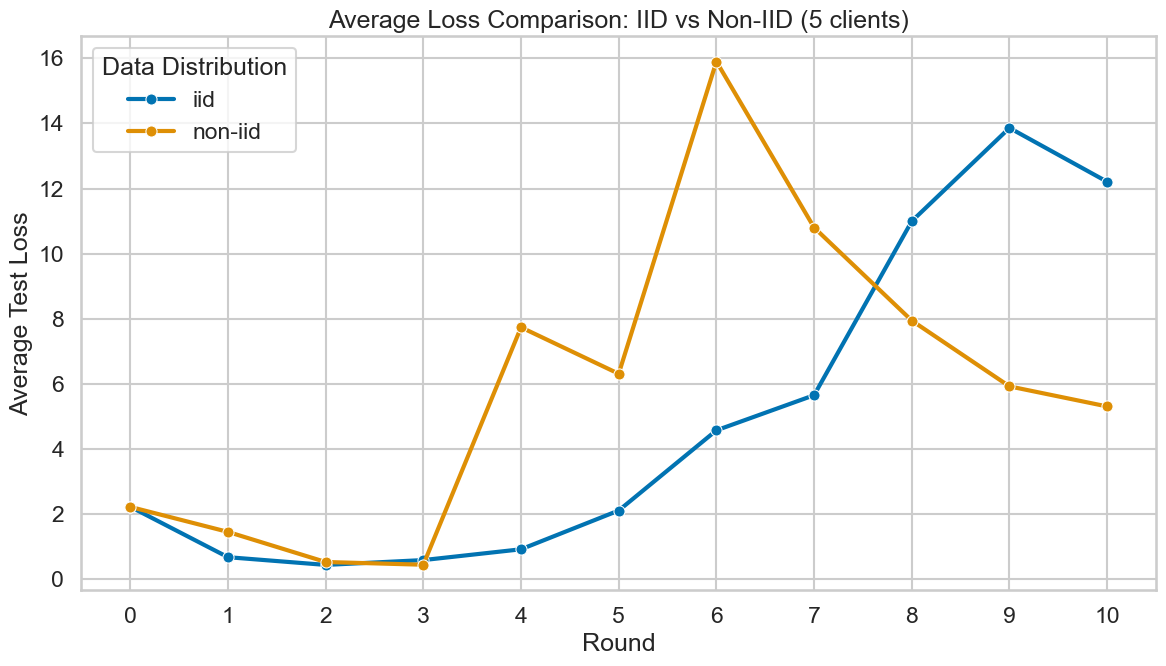

In [ ]:

# IID vs Non-IID Comparison 
data_types = ["iid", "non-iid"]

# First, find intersecting combinations
all_data = []
for data_type in data_types:
    df_info = pd.read_csv(f"/Users/julian/projects/University/Period5/FederatedLearning-SNN/{data_type}.csv")
    combos = set(df_info[df_info['num_clients'] == 5][['aggregation', 'method']].apply(tuple, axis=1))
    all_data.append((data_type, combos))

# Find intersection
iid_combos = all_data[0][1] if all_data[0][0] == 'iid' else all_data[1][1]
non_iid_combos = all_data[1][1] if all_data[1][0] == 'non-iid' else all_data[0][1]
intersecting_combos = iid_combos.intersection(non_iid_combos)

print(f"IID combinations: {iid_combos}")
print(f"Non-IID combinations: {non_iid_combos}")
print(f"Intersecting combinations: {intersecting_combos}")

# Now process data with filtering
all_avg_dfs = []
for data_type in data_types:
    print(f"Processing {data_type} data for comparison...")
    
    # Read metadata CSV
    df_info = pd.read_csv(f"/Users/julian/projects/University/Period5/FederatedLearning-SNN/{data_type}.csv")
    
    # Convert TF events to CSV
    tf_event_files = []
    for _, row in df_info.iterrows():
        folder = os.path.dirname(row["filepath"])
        filename = os.path.basename(row["filepath"])
        tf_event_files.append((folder, filename, row["aggregation"], row["method"], row["num_clients"]))

    for folder, filename, agg, method, n_clients in tf_event_files:
        os.makedirs(folder, exist_ok=True)
        full_path = os.path.join(folder, filename)
        convert_tf_to_csv(full_path, folder)

    # Build metadata for converted CSVs
    all_metadata = []
    for folder, filename, agg, method, n_clients in tf_event_files:
        files = [f for f in os.listdir(folder) if f.endswith(f"centralized_{plot__}.csv") or f.endswith(standal_csv_name)]
        for f in files:
            all_metadata.append({
                "filepath": os.path.join(folder, f),
                "aggregation": agg,
                "method": method,
                "num_clients": n_clients
            })

    df_meta = pd.DataFrame(all_metadata)

    # Load CSV data - RESET all_dfs for each data type
    all_dfs = []  # Reset here!
    for idx, row in df_meta.iterrows():
        try:
            df = pd.read_csv(row['filepath'], encoding='latin1')
            df['aggregation'] = row['aggregation']
            df['method'] = row['method']
            df['num_clients'] = row['num_clients']
            all_dfs.append(df)
        except Exception as e:
            print(f"Skipping {row['filepath']} due to error: {e}")
    
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)

        # Filter to 5 clients, first 10 steps, AND intersecting combinations only
        filtered_df = combined_df[
            (combined_df['num_clients'] == 5) &
            (combined_df['step'] <= 10) &
            (combined_df[['aggregation', 'method']].apply(tuple, axis=1).isin(intersecting_combos))
        ]

        # Calculate average across ONLY intersecting experiments
        if not filtered_df.empty:
            avg_df = filtered_df.groupby('step', as_index=False)['value'].mean()
            avg_df['data_type'] = data_type
            all_avg_dfs.append(avg_df)
            print(f"Added {data_type} average with {len(avg_df)} points (intersecting only)")

# Create comparison plot
if len(all_avg_dfs) >= 2:

    comparison_df = pd.concat(all_avg_dfs, ignore_index=True)

    plt.figure(figsize=(12, 7))
    sns.lineplot(
        data=comparison_df,
        x='step', y='value',
        hue='data_type',
        marker='o',
        linewidth=3,
        markersize=8
    )
    plt.title(f"Average {plot__.capitalize()} Comparison: IID vs Non-IID (5 clients)")
    plt.xlabel("Round")
    plt.ylabel(f"Average Test {plot__.capitalize()}")
    plt.legend(title="Data Distribution")
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    plt.xlim(-0.5, 10.5)
    plt.xticks(range(11))
    plt.tight_layout()

    # Save comparison plot
    comparison_filepath = os.path.join(plots_folder, "iid_vs_non-iid_comparison.png")
    plt.savefig(comparison_filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {comparison_filepath}")
    plt.show()
else:
    print("Not enough data types to create comparison plot")